# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

The goal of this project is to build, train, test and apply a CNN (modified LeNet) classifier in order to classify traffic signs.

---
## Step 0: Load The Data

In [1]:
# Imports
import os
import glob
import copy
import math
import pickle
import hashlib
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
train = pickle.load(open('data/train.p', 'rb'))
valid = pickle.load(open('data/valid.p', 'rb'))
test = pickle.load(open('data/test.p', 'rb'))
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = x_train.shape[0]


# Number of validation examples
n_validation = x_valid.shape[0]


# Number of testing examples
n_test = x_test.shape[0]


# Shape of a traffic sign image
image_shape = tuple(x_train.shape[1:3])


# How many unique classes/labels there are in the dataset
n_classes = np.unique(y_train).shape[0]


# Print the summary
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape, "each with", x_train.shape[3], " color channels")
print("Number of classes =", n_classes)


# Get the dictionary of sign types
print('types of sign:')
dictionary = pd.read_csv('data/signnames.csv')
print(dictionary['SignName'])

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32) each with 3  color channels
Number of classes = 43
types of sign:
0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vehicles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14            

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

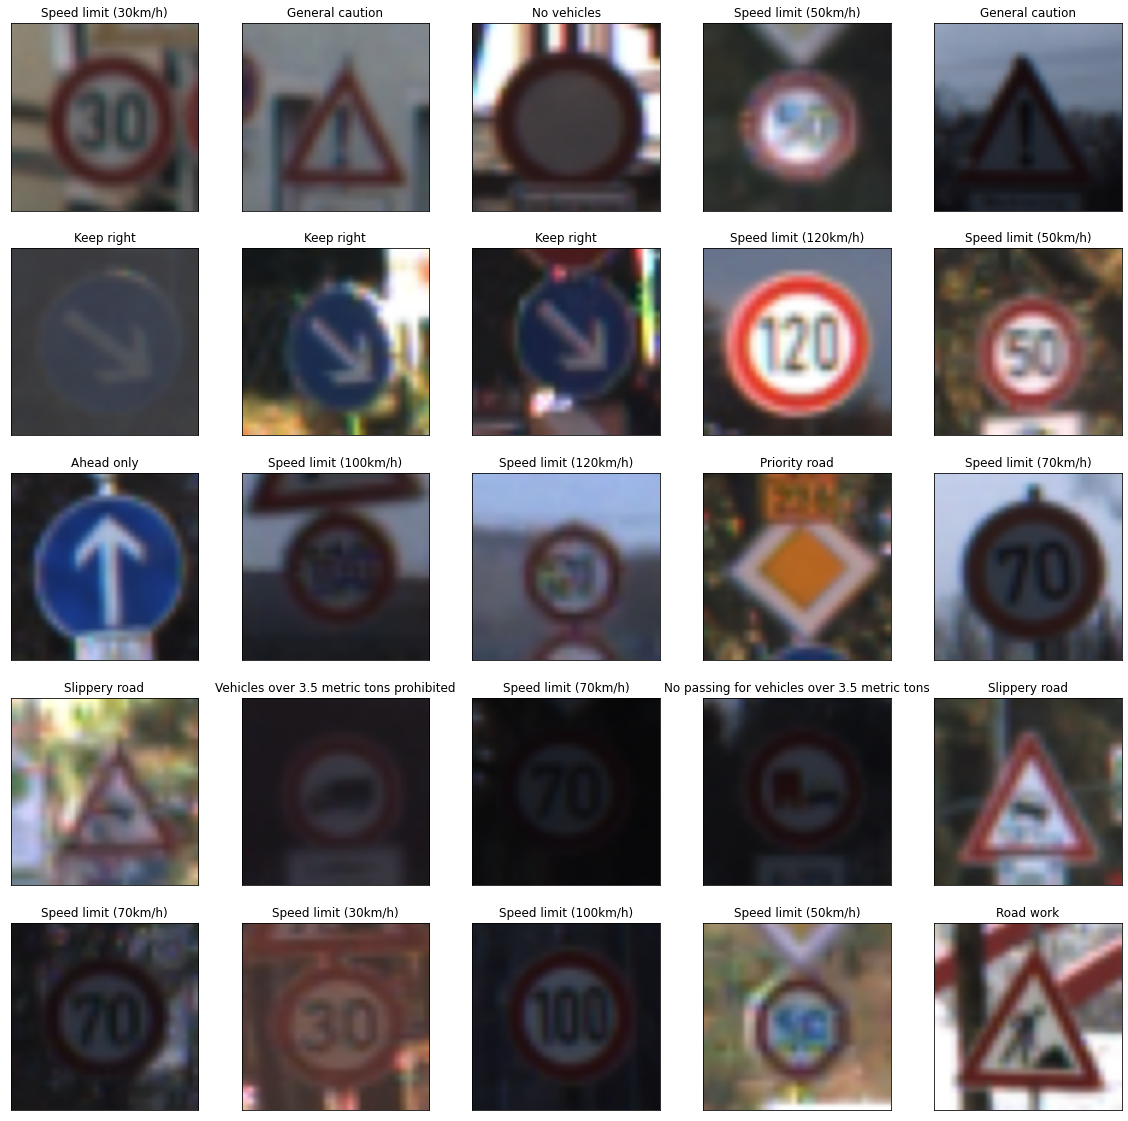

In [3]:
# Plot some training data
plt.rcParams["figure.figsize"] = [20, 20]
fig, axs = plt.subplots(5, 5)
np.random.seed(0)
indices = np.random.randint(0, n_train, size=25)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].imshow(x_train[indices[k], :, :, :], interpolation='hamming')
        axs[i,j].set_title(dictionary.iloc[y_train[indices[k]]]['SignName'])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
        k = k + 1
plt.savefig('results/data.pdf')

       train_count  valid_count  test_count
count    43.000000    43.000000   43.000000
mean    809.279070   102.558140  293.720930
std     626.750855    69.662213  233.442389
min     180.000000    30.000000   60.000000
25%     285.000000    60.000000   90.000000
50%     540.000000    60.000000  180.000000
75%    1275.000000   150.000000  450.000000
max    2010.000000   240.000000  750.000000
                     SignName  train_count  valid_count  test_count
ClassId                                                            
0        Speed limit (20km/h)          180           30          60
1        Speed limit (30km/h)         1980          240         720
2        Speed limit (50km/h)         2010          240         750
3        Speed limit (60km/h)         1260          150         450
4        Speed limit (70km/h)         1770          210         660


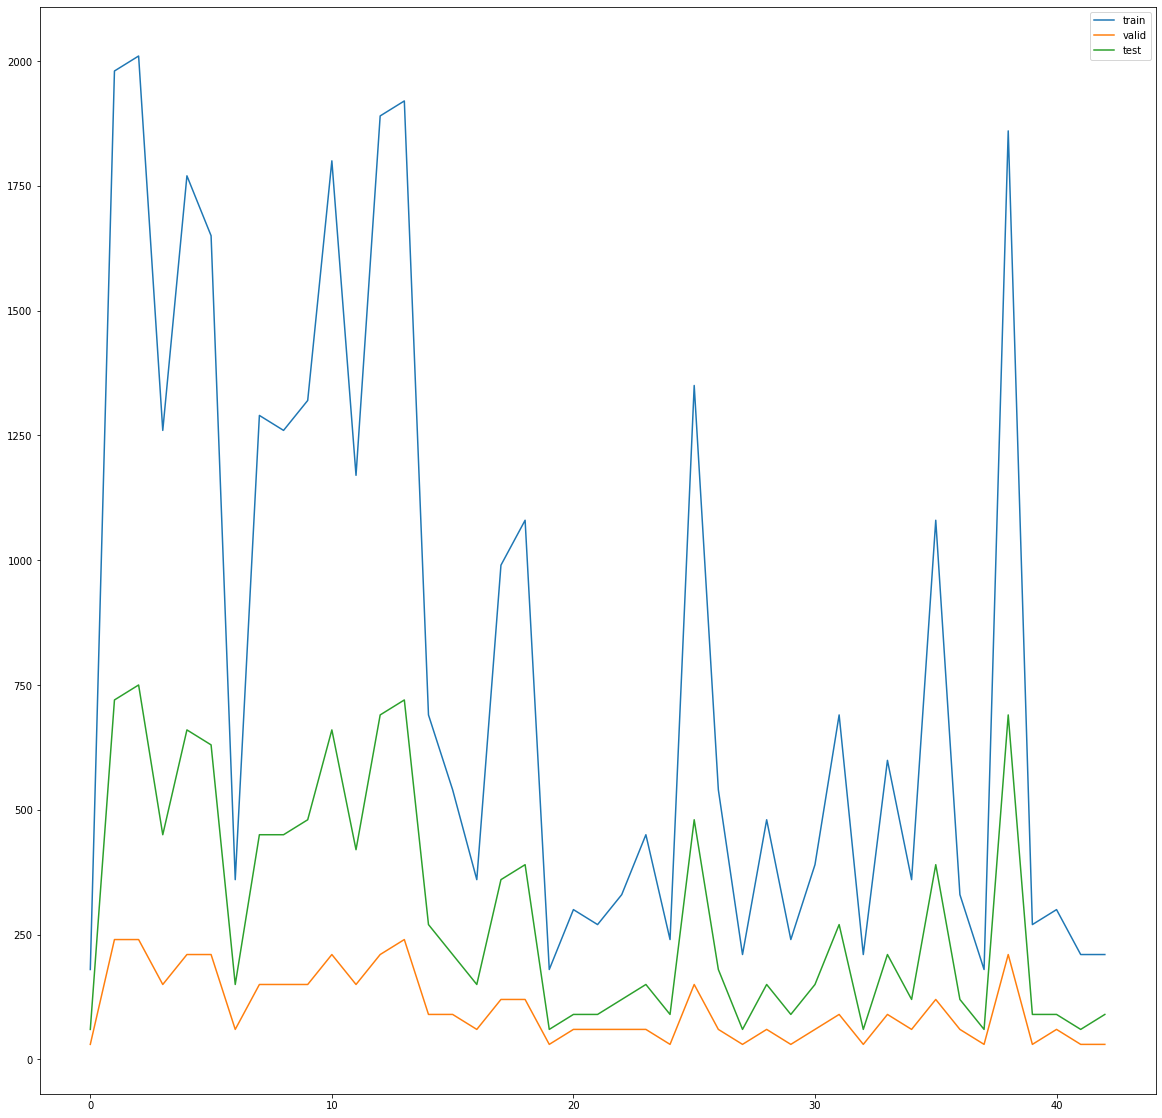

In [4]:
# Plot the distribution of each type for the train, validation and test sets
data = copy.deepcopy(dictionary)
data = data.set_index('ClassId')
data['train_count'] = pd.Series(np.unique(y_train, return_counts=True)[1])
data['valid_count'] = pd.Series(np.unique(y_valid, return_counts=True)[1])
data['test_count'] = pd.Series(np.unique(y_test, return_counts=True)[1])
print(data.describe())
print(data.head())
plt.plot(data.index, data['train_count'], label='train')
plt.plot(data.index, data['valid_count'], label='valid')
plt.plot(data.index, data['test_count'], label='test')
plt.legend()
plt.savefig('results/dist.pdf')

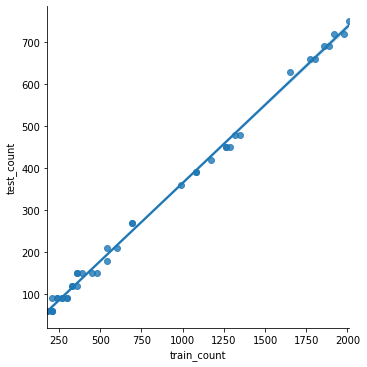

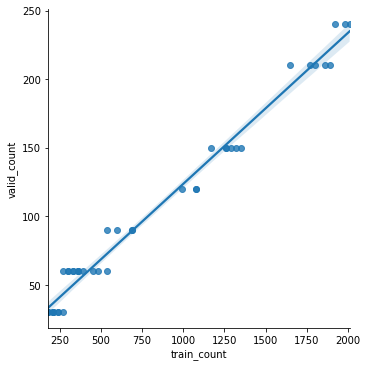

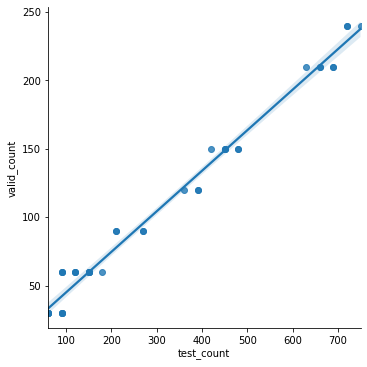

In [5]:
# Plot the distribution of each type for the train, validation and test sets relative to each other
sns.lmplot(data=data, x='train_count', y='test_count')
plt.savefig('results/rel1.pdf')
sns.lmplot(data=data, x='train_count', y='valid_count')
plt.savefig('results/rel2.pdf')
sns.lmplot(data=data, x='test_count', y='valid_count')
plt.savefig('results/rel3.pdf')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
# Normalise x values 
x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255


# Ensure mean of zero
x_train = x_train - np.mean(x_train)
x_valid = x_valid - np.mean(x_valid)
x_test = x_test - np.mean(x_test)


# Shuffle the data
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
x_valid, y_valid = shuffle(x_valid, y_valid)
x_test, y_test = shuffle(x_test, y_test)


# Print x and y shapes and x mean
print(x_train.shape)
print(y_train.shape)
print(np.mean(x_train))

(34799, 32, 32, 3)
(34799,)
1.3957042356230782e-16


### Model Architecture

In [7]:
# Hyper paameters
EPOCHS = 50
BATCH_SIZE = 150
LEARNING_RATE = 0.0009
DROP = 0.75


# Define LeNet structure
keep = tf.placeholder(tf.float32)
def LeNet(x):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    fc0 = flatten(conv2)
    fc0 = tf.nn.dropout(fc0, keep)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 150), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(150))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep) 
    fc2_W = tf.Variable(tf.truncated_normal(shape=(150, 100), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(100))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep) 
    fc3_W = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    return logits


# Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)


# Define model
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)


# Define evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


# Evaluation function
def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = (
            x_data[offset : offset + BATCH_SIZE],
            y_data[offset : offset + BATCH_SIZE],
        )
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep: 1.0})
        total_accuracy += accuracy * len(batch_x)
    return total_accuracy / num_examples




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# Train the model
from sklearn.utils import shuffle
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep: DROP})
        training_accuracy = evaluate(x_train, y_train)
        validation_accuracy = evaluate(x_valid, y_valid)
        print("EPOCH {} ...".format(i + 1))
        print("Training Accuracy  = {0:.1f}%, Validation Accuracy = {1:.1f}%".format(training_accuracy*100, validation_accuracy*100))
        print()
    saver.save(sess, "models/lenet")
    print("Model saved")



Training...



2021-07-21 00:01:38.730267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-21 00:01:38.764413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-21 00:01:38.765172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1650 major: 7 minor: 5 memoryClockRate(GHz): 1.56
pciBusID: 0000:01:00.0
2021-07-21 00:01:38.765490: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2021-07-21 00:01:38.765643: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared ob


EPOCH 1 ...
Training Accuracy  = 68.5%, Validation Accuracy = 60.5%

EPOCH 2 ...
Training Accuracy  = 87.6%, Validation Accuracy = 80.9%

EPOCH 3 ...
Training Accuracy  = 93.0%, Validation Accuracy = 88.0%

EPOCH 4 ...
Training Accuracy  = 95.2%, Validation Accuracy = 90.0%

EPOCH 5 ...
Training Accuracy  = 96.8%, Validation Accuracy = 91.6%

EPOCH 6 ...
Training Accuracy  = 97.6%, Validation Accuracy = 92.4%

EPOCH 7 ...
Training Accuracy  = 98.2%, Validation Accuracy = 93.2%

EPOCH 8 ...
Training Accuracy  = 98.3%, Validation Accuracy = 93.7%

EPOCH 9 ...
Training Accuracy  = 98.6%, Validation Accuracy = 93.2%

EPOCH 10 ...
Training Accuracy  = 98.8%, Validation Accuracy = 94.3%

EPOCH 11 ...
Training Accuracy  = 99.1%, Validation Accuracy = 94.6%

EPOCH 12 ...
Training Accuracy  = 99.1%, Validation Accuracy = 94.7%

EPOCH 13 ...
Training Accuracy  = 99.3%, Validation Accuracy = 95.1%

EPOCH 14 ...
Training Accuracy  = 99.4%, Validation Accuracy = 95.6%

EPOCH 15 ...
Training Accura

In [10]:
# Evaluate the model
with tf.Session() as sess:
    saver.restore(sess, "models/lenet")
    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {0:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from models/lenet


2021-07-21 00:08:53.858081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-21 00:08:53.858102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Test Accuracy = 95.1%


---

## Step 3: Test a Model on New Images

In order to test the model on some new images, I 'drove' around Dresden using Google Street view, and took some frames containing street signs. I will use openCV to preprocess the images, extracting the part of the image containing the street sign, I will then run each of these through the model and analyze the performance.

### Load and Output the Images

In [11]:
# Load in the 5 Steet View frames
image_files = glob.glob("signs/ts*.png")
images = []
for imf in image_files:
    image = cv2.cvtColor(cv2.imread(imf) , cv2.COLOR_BGR2RGB)
    images.append(image)


# Use the perspective transform function from the advanced lane lines computer vision model
def perspective_transform(image, source, destination):
    """Function to change the perspective on an image, mapping the source points to the destination points.
    Parameters:
        image (np.array) : Image to be corrected.
        source (np.array) : 2*N numpy array of N source points in 2D space.
        destination (np.array) : 2*N numpy array of N destination points in 2D space.
    Returns:
        warped (np.array) : Warped image.
        M (np.array) : Warping matrix.
        Minv (np.array) : Inverse of warping matrix.
    """
    image = copy.deepcopy(image)
    image_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(source, destination)
    Minv = cv2.getPerspectiveTransform(destination, source)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv


# Extract the traffic signs using perspective transform.
image_size = (images[0].shape[1], images[0].shape[0])
sources = (np.float32([[800, 250], [800, 200], [835, 200], [835, 250]]), np.float32([[810, 320], [810, 270], [860, 270], [860, 320]]), np.float32([[80, 470], [80, 340], [190, 340], [190, 470]]), np.float32([[795, 290], [795, 220], [865, 220], [865, 290]]), np.float32([[780,320], [780, 220], [870, 220], [870, 320]]))
destinations = (np.float32([[0, 720], [0, 0], [1080, 0], [1080, 720]]),)*5
x_new = np.zeros(shape=(5,32,32,3), dtype=int)
y_new = np.zeros(shape=(5,), dtype=int)
draws = []
for i, im in enumerate(images):
    warped, M, Minv = perspective_transform(im, sources[i], destinations[i])
    warped = cv2.resize(warped, (32,32))
    draw = cv2.polylines(copy.deepcopy(im), [np.int32(sources[i]).reshape((-1, 1, 2))], True, (0, 255, 255), thickness=10)
    draws.append(draw)
    x_new[i,:,:,:] = warped
    
    
# Define correct result
y_new[0] = 1
y_new[1] = 12
y_new[2] = 38
y_new[3] = 35
y_new[4] = 13


# Print shapes of new data
print(x_new.shape)
print(y_new.shape)

(5, 32, 32, 3)
(5,)


### Predict the Sign Type for Each Image

In [12]:
# Predict using the model
with tf.Session() as sess:
    saver.restore(sess, "models/lenet")
    y_pred = sess.run(logits, feed_dict={x : x_new, keep: 1.0})
for i in range(5):
    print(np.argmax(y_pred[i]), y_new[i])

INFO:tensorflow:Restoring parameters from models/lenet
1 1
12 12
38 38
35 35
13 13


2021-07-21 00:09:01.845211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-21 00:09:01.845250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


### Analyze Performance

The model predicts 100% of the Dresden street signs correctly.

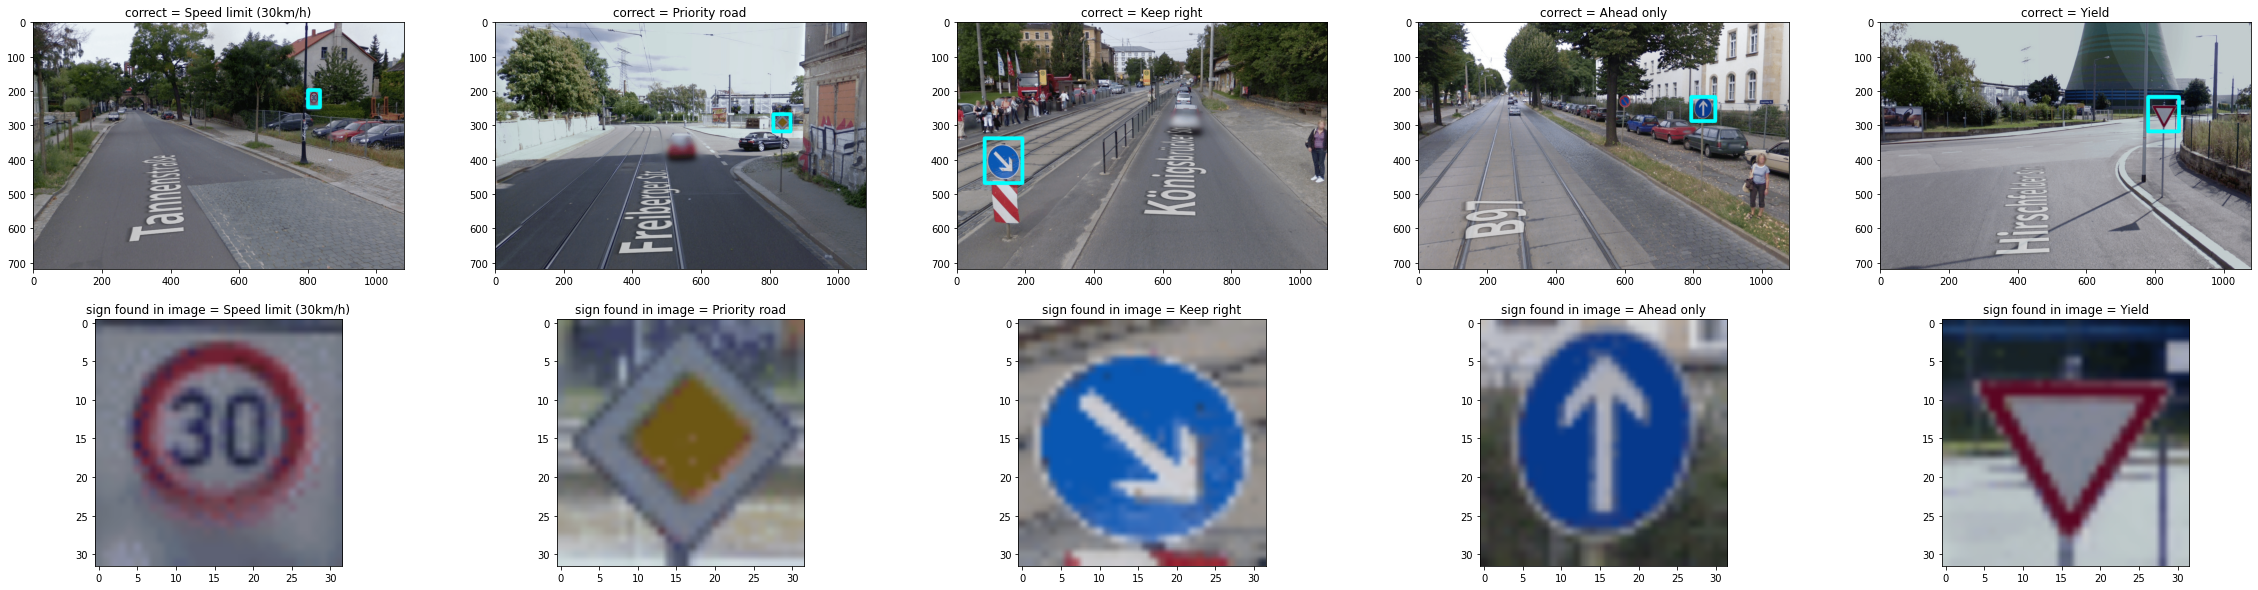

In [13]:
# Plot result
plt.rcParams["figure.figsize"] = [40, 10]
fig, axs = plt.subplots(2, len(images))
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i == 0:
            a.set_title('correct = {}'.format(dictionary.iloc[y_new[j]]['SignName']))
            a.imshow(draws[j])
        if i == 1:
            a.set_title('sign found in image = {}'.format(dictionary.iloc[np.argmax(y_pred[j])]['SignName']))
            a.imshow(x_new[j,:,:,:], interpolation='hamming')
plt.savefig('results/new.pdf')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the certainty of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. In our cade the model has an **very high certainty (1)** when appied to the Dresden images:

In [14]:
# Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
softmax = tf.nn.softmax(logits)
topk = tf.nn.top_k(softmax, k=5)
with tf.Session() as sess:
    saver.restore(sess, "models/lenet")
    tk = sess.run(topk, feed_dict={x : x_new, keep: 1.0})
print(tk)

INFO:tensorflow:Restoring parameters from models/lenet
TopKV2(values=array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32), indices=array([[ 1,  0,  2,  3,  4],
       [12,  0,  1,  2,  3],
       [38,  0,  1,  2,  3],
       [35,  0,  1,  2,  3],
       [13,  0,  1,  2,  3]], dtype=int32))


2021-07-21 00:09:14.300957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-21 00:09:14.301007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
